___
# Logistic Regression Models
___

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_auc_score, \
recall_score, precision_score, f1_score

### Examine data

In [2]:
# Load data
df = pd.read_csv('../data/merged_pulls.csv')
transactions = pd.read_csv('../data/merged_logs.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2422 entries, 0 to 2421
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   time_pulled    2422 non-null   object
 1   fullname       1976 non-null   object
 2   titles         2422 non-null   object
 3   times_created  2422 non-null   object
 4   anchors        2252 non-null   object
 5   subreddit      2422 non-null   object
dtypes: object(6)
memory usage: 113.7+ KB


In [3]:
# Checking that our target vector is a binary classification
df['subreddit'].unique()

array(['nfl', 'nhl'], dtype=object)

In [4]:
# Assign binary values for target variable
df['subreddit'] = df['subreddit'].map({'nfl': 0, 'nhl': 1})

___
# Null Model
___

In [5]:
print(f'For a classification model, our baseline model is the distribution between \
the two classes.  \nThe NFL is about {round(df['subreddit'].value_counts(normalize=True)[0] * 100, 2)} %. \
of the posts, while the NHL is the remaining {round(df['subreddit'].value_counts(normalize=True)[1] * 100 ,2)} %.')

For a classification model, our baseline model is the distribution between the two classes.  
The NFL is about 62.18 %. of the posts, while the NHL is the remaining 37.82 %.


___
# 01 - Logistic Regression CVEC
___

### Prepare Data for Preprocessing

In [6]:
df.head()

,time_pulled,fullname,titles,times_created,anchors,subreddit
0,Mon Oct 7 14:33:26 2024,t3_1fuhrlu,Comparative offensive line ratings &amp; rank...,2024-10-02 07:39:12,t3_1ftq3sr,0
1,Sat Oct 5 00:41:50 2024,NaN,Most receiving yards through a players’ first...,Sun Sep 29 06:50:08 2024,t3_1frmbek,0
2,Thu Oct 10 16:52:52 2024,t3_1e2fnbj,"""CapWages"" &gt; ""PuckPedia"" (CapFriendly subst...",2024-07-13 10:19:26,t3_1dtu7g2,0
3,Sun Oct 6 19:15:26 2024,t3_1dd4fuo,"""Hey, how's your mother?""",2024-06-10 20:21:28,NaN,0
4,Tue Oct 8 11:34:11 2024,t3_1eqmkdv,"""The original [LeBreton arena] deal was really...",2024-08-12 12:16:14,t3_1ect1g8,1


In [7]:
# Creating matrix
X = df['titles']
y = df['subreddit']

In [8]:
X.head()

0     Comparative offensive line ratings &amp; rank...
1     Most receiving yards through a players’ first...
2    "CapWages" &gt; "PuckPedia" (CapFriendly subst...
3                            "Hey, how's your mother?"
4    "The original [LeBreton arena] deal was really...
Name: titles, dtype: object

In [9]:
# Split data - test size 25%, random state 27 and stratify as our data is slightly stratified
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=27, stratify=y)

### Pipeline and GridSearch

In [10]:
# Building a pipeline for Logisitc Regression with CVEC

pipe1 = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

In [11]:
# Setting up hyperparameters to explore

pipe1_parameters = {
    'cvec__max_features': range(1000, 3000, 500),
    'cvec__stop_words': [None, 'english'],
    'cvec__min_df': [1, 3], 
    'cvec__max_df': [0.3, 0.5],
    'lr__C': np.linspace(0.13, 0.23, 20),
    'lr__multi_class': ['multinomial'],
    'lr__solver': ['lbfgs', 'newton-cg']
}    

### Instantiate and fit model

In [12]:
# Grid Search for best configuration
gs = GridSearchCV(pipe1, 
                 pipe1_parameters,
                 n_jobs=-1,
                  cv=5
                 )

gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.3, 0.5],
                         'cvec__max_features': range(1000, 3000, 500),
                         'cvec__min_df': [1, 3],
                         'cvec__stop_words': [None, 'english'],
                         'lr__C': array([0.13      , 0.13526316, 0.14052632, 0.14578947, 0.15105263,
       0.15631579, 0.16157895, 0.16684211, 0.17210526, 0.17736842,
       0.18263158, 0.18789474, 0.19315789, 0.19842105, 0.20368421,
       0.20894737, 0.21421053, 0.21947368, 0.22473684, 0.23      ]),
                         'lr__multi_class': ['multinomial'],
                         'lr__solver': ['lbfgs', 'newton-cg']})

### Evaluate

In [13]:
# The GridSearch best results
pipe1_best_params = pd.Series(gs.best_params_)
print('================================================')
print(f'The GridSearch best score was {round(gs.best_score_ * 100, 2)} %.')
print('================================================')
pipe1_best_params

The GridSearch best score was 72.02 %.


cvec__max_df                  0.3
cvec__max_features           2500
cvec__min_df                    1
cvec__stop_words             None
lr__C                    0.135263
lr__multi_class       multinomial
lr__solver                  lbfgs
dtype: object

In [14]:
# Scoring results on training and testing set
print(f'Training data score: {round(gs.score(X_train, y_train) *100, 2)} %.')
print(f'Testing data score: {round(gs.score(X_test, y_test) *100, 2)} %.')

Training data score: 87.44 %.
Testing data score: 75.58 %.


In [15]:
# Evaluate predictions
preds1 = gs.predict(X_test)

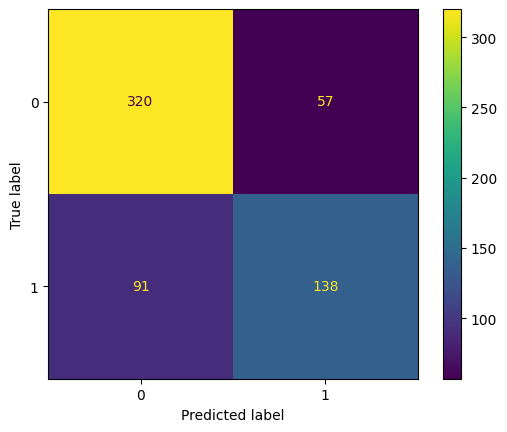

In [16]:
# View them in a confustion matrix
tn, fp, fn, tp = confusion_matrix(y_test, preds1).ravel()

cmd = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, preds1),
                             display_labels=gs.classes_)

cmd.plot();

In [17]:
# Common Metrics

# Specificity
spec = tn / (tn+fp)
print(f'The specificity was {round(spec * 100, 2)} %.')
print('**************************************')

# Sensitivity
print(f'The sensitivity was {round(recall_score(y_test, preds1) * 100, 2)} %.')
print('**************************************')

# Precision
print(f'The precision was {round(precision_score(y_test, preds1) * 100, 2)} %.')
print('**************************************')

# F1 Score
print(f'The F1 score was {round(f1_score(y_test, preds1) * 100, 2)} %.')
print('**************************************')

The specificity was 84.88 %.
**************************************
The sensitivity was 60.26 %.
**************************************
The precision was 70.77 %.
**************************************
The F1 score was 65.09 %.
**************************************


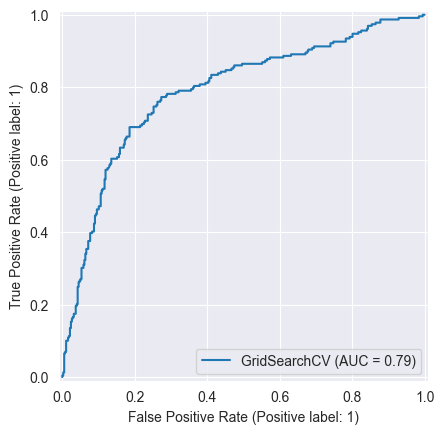

In [33]:
# Roc Curve
sns.set_style('darkgrid')
RocCurveDisplay.from_estimator(gs, X_test, y_test)
plt.legend;
plt.savefig('../assets/logreg_tvec_roc_auc.jpg');
plt.show();

In [19]:
# The curve is pretty average, checking the area under the curve
print(f'The ROC AUC score is {round(roc_auc_score(y_test, preds1) * 100, 2)} %. \
     \nThis is a ok score, 1.0 being the best and 0.5 being the worst. \
     \nThis leaves room for improvement.')

The ROC AUC score is 72.57 %.      
This is a ok score, 1.0 being the best and 0.5 being the worst.      
This leaves room for improvement.


### Logisitic Regression CVEC Evaluation

The first model was a Logistic Regression that was fit by a CountVectorizer (CVEC) transformer.  CVEC works by counting up the words across all documents.  

After tinkering with the hyperparameters in the GridSearch, the best configuration landed on an overfit model.  The model was roughly 75% accurate on the testing data (87% on the training data).  

As we don't particularly care if the post is related to the NFL or NHL, we want to optimize the F1 score, the balance between being right for both classes (the harmonic mean between precision and recall).  The F1 score was only 65%, not terribly strong.

To look at it the other way, we can look at the ROC curve.  This is telling us the trade off between sensitivity (true positives) vs specificity (false positives) or how well our model is at diffentiating between classes.  Ideally we want to see a right angle.  A bad mode will be a line that is 45 degrees out from 0.  There we see a 72.5%, just below average.

Given these results (based on the count of words), the project will move to a Term Frequency-Inverse Document Frequency (TVEC) transfomer to try to find better relationships and indicators in the words.  TVEC works by finding words that carry more predictive powers.  They show up in some documents, but not at all in others.  So when they are used, they have a stronger indication.

___
# 02 - Logistic Regression TVEC
___

In [20]:
# Building a pipeline for Logisitc Regression with TVEC

pipe2 = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('lr', LogisticRegression())
])

In [21]:
# Setting up hyperparameters to explore
pipe2_parameters = {
    'tvec__max_features': range(0, 3000, 500),
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1, 2), (2, 3)],
    'lr__penalty': ['l1', 'l2'],
    'lr__C': np.linspace(0.23, 0.33, 20),
    'lr__multi_class': ['multinomial'],
    'lr__solver': ['saga', 'liblinear']
}    

In [22]:
# Grid Search for best configuration
gs2 = GridSearchCV(pipe2, 
                 pipe2_parameters,
                 n_jobs=-1,
                  cv=5
                 )

gs2.fit(X_train, y_train)

C:\Users\paddy\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py:547: FitFailedWarning: 
5600 fits failed out of a total of 9600.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1600 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\paddy\anaconda3\Lib\site-packages\sklearn\model_selection\_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\paddy\anaconda3\Lib\site-packages\sklearn\base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\paddy\anaconda3\Lib\site-packages\sklearn\pipeline.py", line 471, in fit
    Xt = self._fit(X, y

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'lr__C': array([0.23      , 0.23526316, 0.24052632, 0.24578947, 0.25105263,
       0.25631579, 0.26157895, 0.26684211, 0.27210526, 0.27736842,
       0.28263158, 0.28789474, 0.29315789, 0.29842105, 0.30368421,
       0.30894737, 0.31421053, 0.31947368, 0.32473684, 0.33      ]),
                         'lr__multi_class': ['multinomial'],
                         'lr__penalty': ['l1', 'l2'],
                         'lr__solver': ['saga', 'liblinear'],
                         'tvec__max_features': range(0, 3000, 500),
                         'tvec__ngram_range': [(1, 2), (2, 3)],
                         'tvec__stop_words': [None, 'english']})

### Evaluate

In [23]:
# The GridSearch best results
pipe2_best_params = pd.Series(gs2.best_params_)
print('================================================')
print(f'The GridSearch best score was {round(gs2.best_score_ * 100, 2)} %.')
print('================================================')
pipe2_best_params

The GridSearch best score was 70.59 %.


lr__C                    0.303684
lr__multi_class       multinomial
lr__penalty                    l2
lr__solver                   saga
tvec__max_features           1000
tvec__ngram_range          (1, 2)
tvec__stop_words          english
dtype: object

In [24]:
# Scoring results on training and testing set
print(f'Training data score: {round(gs2.score(X_train, y_train) *100, 2)} %.')
print(f'Testing data score: {round(gs2.score(X_test, y_test) *100, 2)} %.')

Training data score: 78.85 %.
Testing data score: 74.92 %.


In [25]:
# Evaluate predictions
preds2 = gs2.predict(X_test)

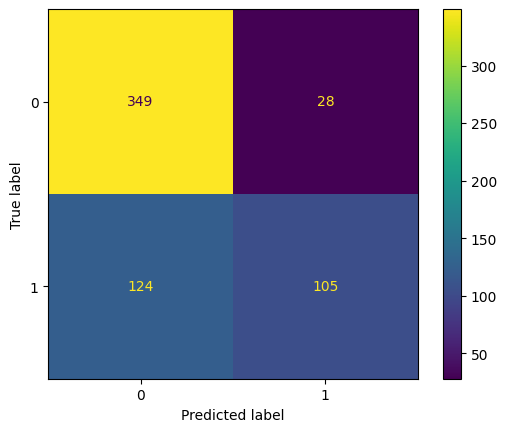

In [26]:
# View them in a confustion matrix
tn2, fp2, fn2, tp2 = confusion_matrix(y_test, preds2).ravel()

cmd2 = ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, preds2),
                             display_labels=gs2.classes_)

cmd2.plot();

In [27]:
# A lot of false negatives
tp2

105

In [28]:
# Common Metrics

# Specificity
spec2 = tn2 / (tn2+fp2)
print(f'The specificity was {round(spec2 * 100, 2)} %.')
print('**************************************')

# Sensitivity
print(f'The sensitivity was {round(recall_score(y_test, preds2) * 100, 2)} %.')
print('**************************************')

# Precision
print(f'The precision was {round(precision_score(y_test, preds2) * 100, 2)} %.')
print('**************************************')

# F1 Score
print(f'The F1 score was {round(f1_score(y_test, preds2) * 100, 2)} %.')
print('**************************************')

The specificity was 92.57 %.
**************************************
The sensitivity was 45.85 %.
**************************************
The precision was 78.95 %.
**************************************
The F1 score was 58.01 %.
**************************************


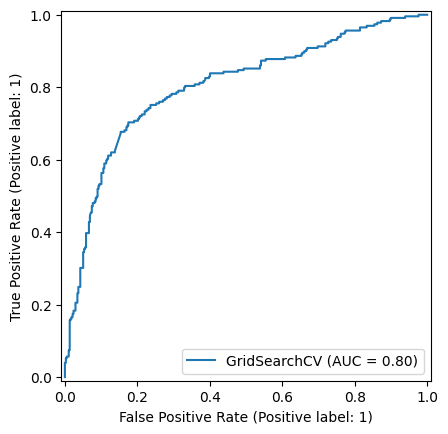

In [29]:
# Roc Curve
RocCurveDisplay.from_estimator(gs2, X_test, y_test)
plt.legend;
plt.show();

In [30]:
# The curve is quite squre, checking the area under the curve
print(f'The ROC AUC score is {round(roc_auc_score(y_test, preds2) * 100, 2)} %. \
     \nThis is a worse score, 1.0 being the best and 0.5 being the worst.')

The ROC AUC score is 69.21 %.      
This is a worse score, 1.0 being the best and 0.5 being the worst.


### Logisitic Regression TVEC Evaluation

The first model was a Logistic Regression that was fit with a CountVectorizer (CVEC) transformer and appears to be better at handling the data in some metrics. (I did try putting both transformers in a GridSearch pipeline, but my router crashed).  

This TVEC transformed model is not as overfit to the data as the CVEC model, measuring 75% accuracy on the test data and 79% on the training data.  The TVEC model had an impressive 92% specificity rating to a lower 46% sensitivity.  

Critically for us, its F1 score is a bit lower at 58%, a 7% percent drop compared to the CVEC model.  Its ROC AUC score also dropped down to 69%.  

If we were going to rely on a logisitc regression model we could consider undersampling and oversampling methods as well as synthetic boosting to balance the classes a bit better

We will keep these results in mind as we compare it to other models.  Next we will see how a kNN model performs.